In [88]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from functools import partial
from sklearn.model_selection import train_test_split
import tempfile
import matplotlib.pyplot as plt
import pydicom 
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import cv2

sns.set_style("whitegrid")


Data Exploration

In [89]:
list(os.listdir('../input/siim-isic-melanoma-classification'))

['sample_submission.csv',
 'jpeg',
 'tfrecords',
 'train.csv',
 'test.csv',
 'test',
 'train']

In [90]:
directory = '../input/siim-isic-melanoma-classification'

train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

new_names = ['image_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


In [91]:
train_df.head()

image_name          ID     sex   age          anatomy diagnosis  \
0  ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1  ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2  ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3  ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4  ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   

  benign_malignant  target  
0           benign       0  
1           benign       0  
2           benign       0  
3           benign       0  
4           benign       0

In [92]:
test_df.head()

image_name          ID     sex   age          anatomy
0  ISIC_0052060  IP_3579794    male  70.0              NaN
1  ISIC_0052349  IP_7782715    male  40.0  lower extremity
2  ISIC_0058510  IP_7960270  female  55.0            torso
3  ISIC_0073313  IP_6375035  female  50.0            torso
4  ISIC_0073502  IP_0589375  female  45.0  lower extremity

In [93]:
train_df.isnull().sum()

image_name            0
ID                    0
sex                  65
age                  68
anatomy             527
diagnosis             0
benign_malignant      0
target                0
dtype: int64

In [94]:
test_df.isnull().sum()

image_name      0
ID              0
sex             0
age             0
anatomy       351
dtype: int64

In the training dataset there are 65 missing values for sex, 68 missing values for age, and 527 missing values for anatomy. For the test dataset there are 351 values missing for anatomy. This number of missing values is not too bad since the datasets are pretty large. 

Out of 65 NAN values, 65 are benign and 0 malignant.


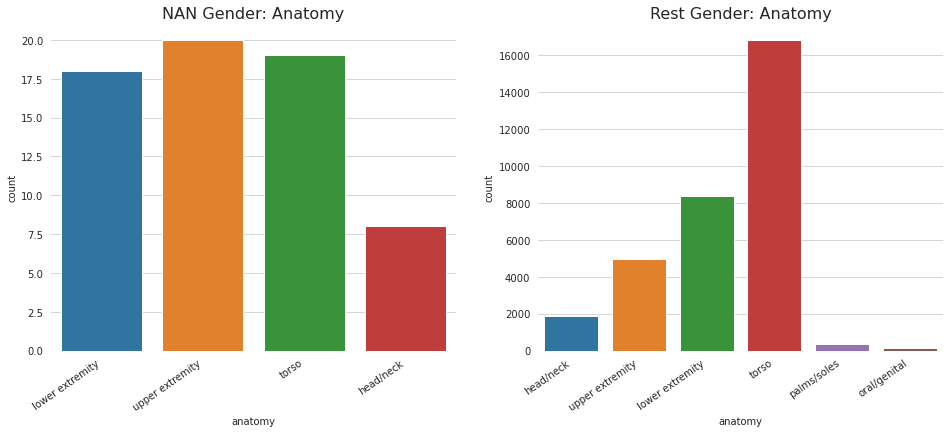

In [95]:
nan_sex = train_df[train_df['sex'].isna() == True]
is_sex = train_df[train_df['sex'].isna() == False]

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(nan_sex['anatomy'], ax = ax1)
b = sns.countplot(is_sex['anatomy'], ax = ax2)
ax1.set_title('NAN Gender: Anatomy', fontsize=16)
ax2.set_title('Rest Gender: Anatomy', fontsize=16)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
sns.despine(left=True, bottom=True);

print('Out of 65 NAN values, {} are benign and 0 malignant.'.format(nan_sex['benign_malignant'].value_counts()[0]))

Since the torso is by far the most common location for melanomas based on the graph on the right and is the second most common location for melanomas based on the graph on the left, this is the location I will use to fill in missing location values. 

In [96]:
train_df['anatomy'].fillna('torso', inplace = True) 

In [97]:
train_df.isnull().sum()

image_name           0
ID                   0
sex                 65
age                 68
anatomy              0
diagnosis            0
benign_malignant     0
target               0
dtype: int64

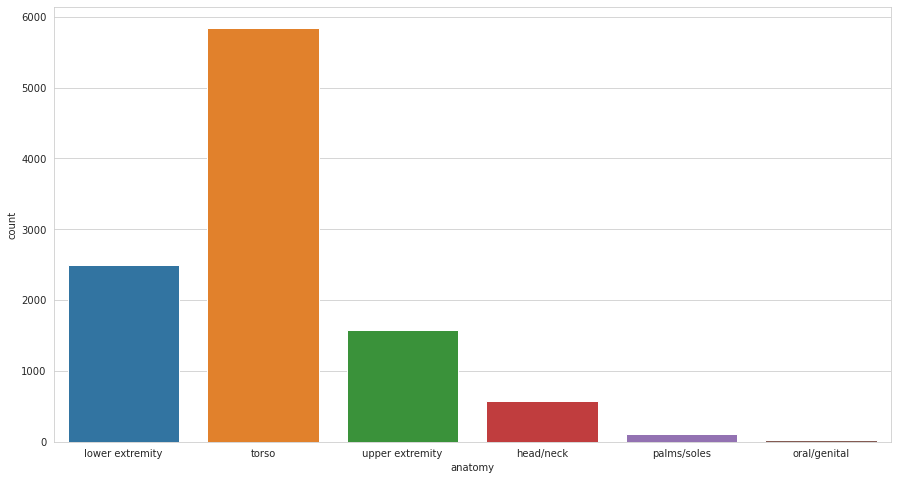

In [98]:
plt.figure(figsize=(15,8))
sns.countplot(test_df['anatomy'])

In [99]:
test_df['anatomy'].fillna('torso', inplace = True) 
test_df.isnull().sum()

image_name    0
ID            0
sex           0
age           0
anatomy       0
dtype: int64

In [100]:
train_df['age'].mean()

48.87001633492649

In [101]:
train_df['age'].median()

50.0

In [102]:
train_df['age'].fillna(50, inplace = True) 

In [103]:
train_df.isnull().sum()

image_name           0
ID                   0
sex                 65
age                  0
anatomy              0
diagnosis            0
benign_malignant     0
target               0
dtype: int64

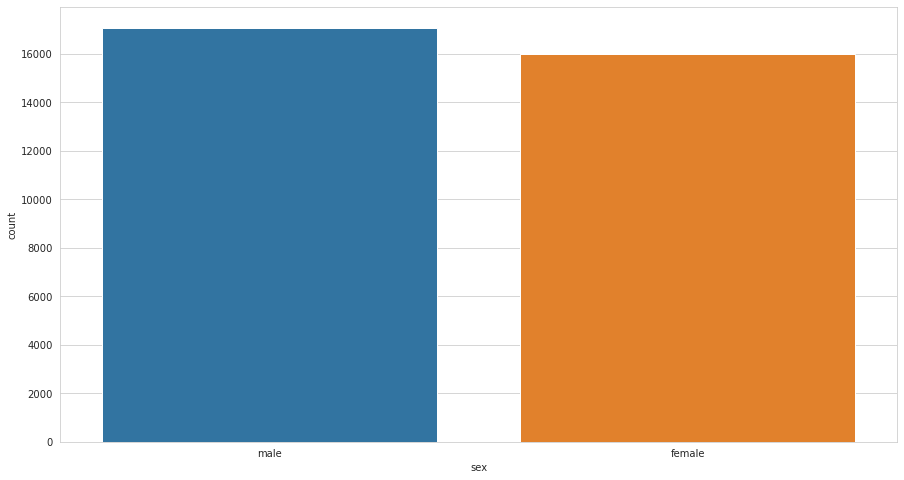

In [104]:
plt.figure(figsize=(15,8))
sns.countplot(train_df['sex'])

In [105]:
train_df['sex'].fillna('male', inplace = True) 

In [106]:
train_df.isnull().sum()

image_name          0
ID                  0
sex                 0
age                 0
anatomy             0
diagnosis           0
benign_malignant    0
target              0
dtype: int64

In [107]:
test_df.isnull().sum()

image_name    0
ID            0
sex           0
age           0
anatomy       0
dtype: int64

In [108]:
train_df.head()

image_name          ID     sex   age          anatomy diagnosis  \
0  ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown   
1  ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown   
2  ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus   
3  ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown   
4  ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown   

  benign_malignant  target  
0           benign       0  
1           benign       0  
2           benign       0  
3           benign       0  
4           benign       0

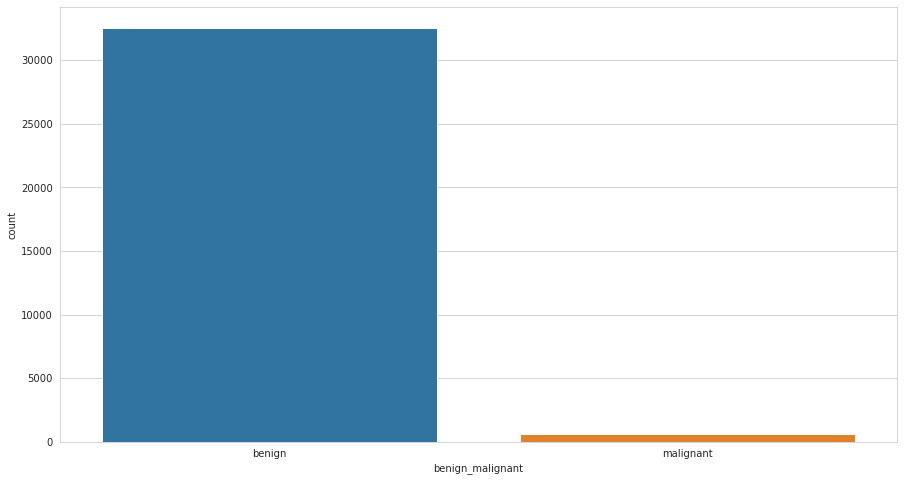

In [109]:
plt.figure(figsize=(15,8))
sns.countplot(train_df['benign_malignant'])

The classes of benign and malignant samples are extremely unbalanced, an issue that will need to be addressed before a model can be accurately fit to the data. 

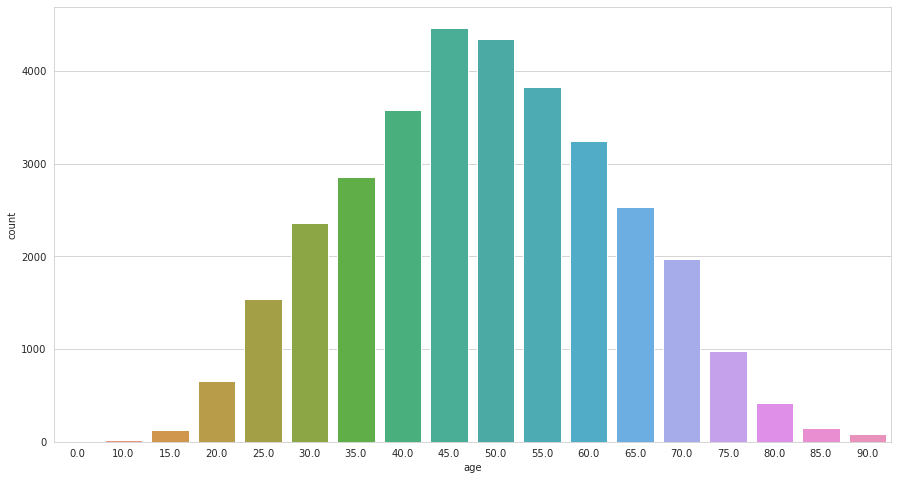

In [110]:
plt.figure(figsize=(15,8))
sns.countplot(train_df['age'])

In [111]:
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

Text(0.5, 1.0, 'Age Distribution by Target Types')

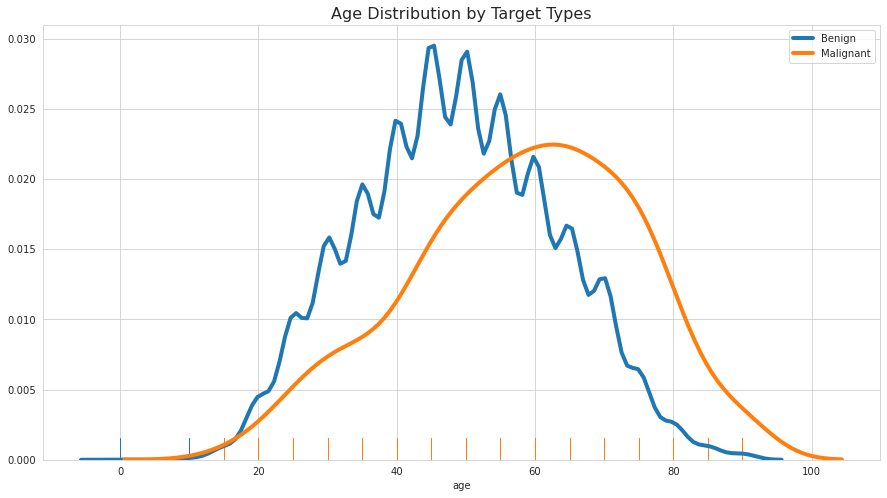

In [112]:
plt.figure(figsize=(15,8))
sns.distplot(a = train_df[train_df['target']==0]['age'], hist=False, rug=True, kde_kws=dict(linewidth=4), 
             label='Benign')
sns.distplot(a = train_df[train_df['target']==1]['age'], hist=False, rug=True, kde_kws=dict(linewidth=4), 
             label='Malignant')
plt.title('Age Distribution by Target Types', fontsize=16)

Text(0.5, 1.0, 'Gender Split by Target Variable')

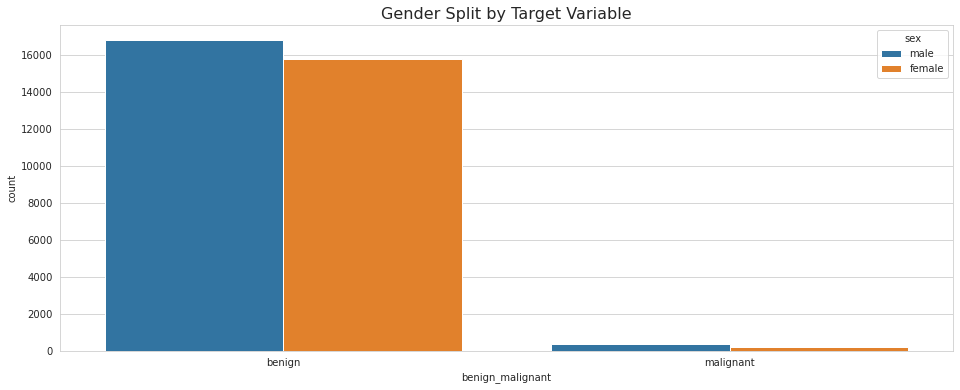

In [113]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train_df, x='benign_malignant', hue='sex')
plt.title('Gender Split by Target Variable', fontsize=16)

Text(0.5, 1.0, 'Anatomy Split by Target Variable')

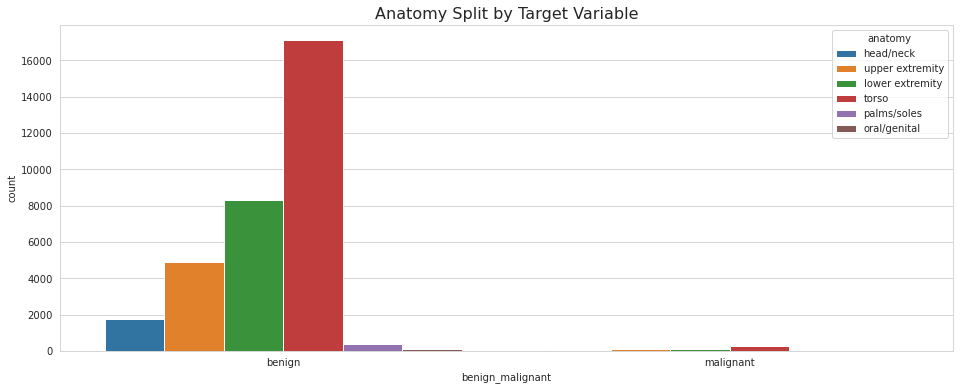

In [114]:
plt.figure(figsize=(16, 6))
sns.countplot(data=train_df, x='benign_malignant', hue='anatomy')
plt.title('Anatomy Split by Target Variable', fontsize=16)

Text(0.5, 1.0, 'Test: Age Distribution')

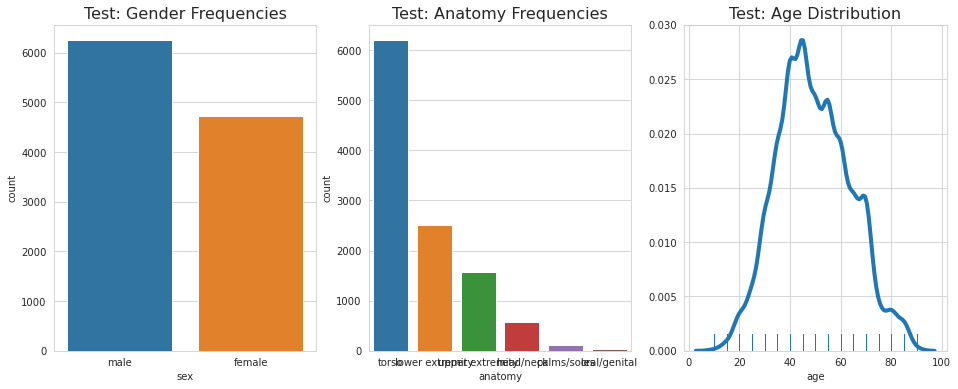

In [115]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.countplot(test_df['sex'], ax=ax1)
b = sns.countplot(test_df['anatomy'], ax=ax2)
c = sns.distplot(a = test_df['age'], ax=ax3, hist=False, rug=True, kde_kws=dict(linewidth=4))


ax1.set_title('Test: Gender Frequencies', fontsize=16)
ax2.set_title('Test: Anatomy Frequencies', fontsize=16)
ax3.set_title('Test: Age Distribution', fontsize=16)

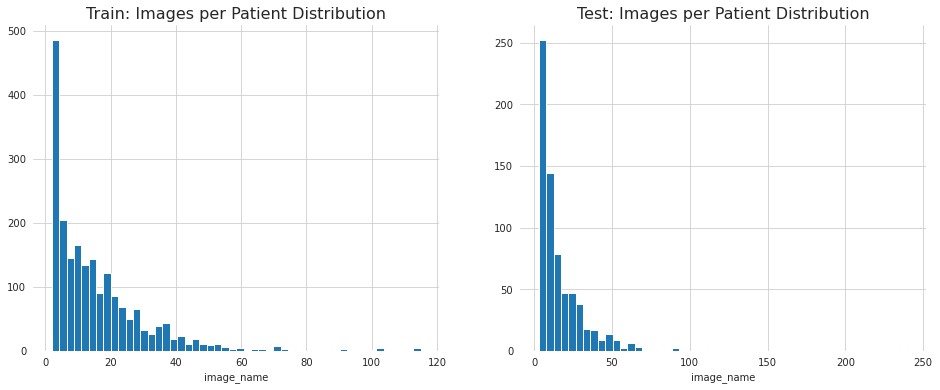

In [116]:
patients_count_train = train_df.groupby(by='ID')['image_name'].count().reset_index()
patients_count_test = test_df.groupby(by='ID')['image_name'].count().reset_index()

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.distplot(patients_count_train['image_name'], kde=False, bins=50, 
                 ax=ax1, hist_kws={'alpha': 1})
b = sns.distplot(patients_count_test['image_name'], kde=False, bins=50, 
                 ax=ax2, hist_kws={'alpha': 1})
    
ax1.set_title('Train: Images per Patient Distribution', fontsize=16)
ax2.set_title('Test: Images per Patient Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

You can see that there are patients with multiple images taken in both the test and training datasets. 

In [117]:
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

Next we will create image paths to allow us to access image features for the images as dicoms and as jpegs. 

In [118]:
path_train = directory + '/train/' + train_df['image_name'] + '.dcm'
path_test = directory + '/test/' + test_df['image_name'] + '.dcm'

# Append to the original dataframes
train_df['path_dicom'] = path_train
test_df['path_dicom'] = path_test

# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + train_df['image_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['image_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

The categorical features will need to be converted to numerical features through one-hot encoding. 

In [119]:
train_df.drop(['benign_malignant'], axis=1, inplace=True)
train_df.head()

image_name          ID     sex   age          anatomy diagnosis  target  \
0  ISIC_2637011  IP_7279968    male  45.0        head/neck   unknown       0   
1  ISIC_0015719  IP_3075186  female  45.0  upper extremity   unknown       0   
2  ISIC_0052212  IP_2842074  female  50.0  lower extremity     nevus       0   
3  ISIC_0068279  IP_6890425  female  45.0        head/neck   unknown       0   
4  ISIC_0074268  IP_8723313  female  55.0  upper extremity   unknown       0   

                                          path_dicom  \
0  ../input/siim-isic-melanoma-classification/tra...   
1  ../input/siim-isic-melanoma-classification/tra...   
2  ../input/siim-isic-melanoma-classification/tra...   
3  ../input/siim-isic-melanoma-classification/tra...   
4  ../input/siim-isic-melanoma-classification/tra...   

                                           path_jpeg  
0  ../input/siim-isic-melanoma-classification/jpe...  
1  ../input/siim-isic-melanoma-classification/jpe...  
2  ../input/siim-isic-melanoma-classification/jpe...  
3  ../input/siim-isic-melanoma-classification/jpe...  
4  ../input/siim-isic-melanoma-classification/jpe...

In [120]:
test_df.head()

image_name          ID     sex   age          anatomy  \
0  ISIC_0052060  IP_3579794    male  70.0            torso   
1  ISIC_0052349  IP_7782715    male  40.0  lower extremity   
2  ISIC_0058510  IP_7960270  female  55.0            torso   
3  ISIC_0073313  IP_6375035  female  50.0            torso   
4  ISIC_0073502  IP_0589375  female  45.0  lower extremity   

                                          path_dicom  \
0  ../input/siim-isic-melanoma-classification/tes...   
1  ../input/siim-isic-melanoma-classification/tes...   
2  ../input/siim-isic-melanoma-classification/tes...   
3  ../input/siim-isic-melanoma-classification/tes...   
4  ../input/siim-isic-melanoma-classification/tes...   

                                           path_jpeg  
0  ../input/siim-isic-melanoma-classification/jpe...  
1  ../input/siim-isic-melanoma-classification/jpe...  
2  ../input/siim-isic-melanoma-classification/jpe...  
3  ../input/siim-isic-melanoma-classification/jpe...  
4  ../input/siim-isic-melanoma-classification/jpe...

In [121]:
to_encode = ['sex', 'anatomy', 'diagnosis']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(train_df[column])
    encoded_all.append(encoded)
    
train_df['sex'] = encoded_all[0]
train_df['anatomy'] = encoded_all[1]
train_df['diagnosis'] = encoded_all[2]


In [122]:
train_df.head()

image_name          ID  sex   age  anatomy  diagnosis  target  \
0  ISIC_2637011  IP_7279968    1  45.0        0          8       0   
1  ISIC_0015719  IP_3075186    0  45.0        5          8       0   
2  ISIC_0052212  IP_2842074    0  50.0        1          5       0   
3  ISIC_0068279  IP_6890425    0  45.0        0          8       0   
4  ISIC_0074268  IP_8723313    0  55.0        5          8       0   

                                          path_dicom  \
0  ../input/siim-isic-melanoma-classification/tra...   
1  ../input/siim-isic-melanoma-classification/tra...   
2  ../input/siim-isic-melanoma-classification/tra...   
3  ../input/siim-isic-melanoma-classification/tra...   
4  ../input/siim-isic-melanoma-classification/tra...   

                                           path_jpeg  
0  ../input/siim-isic-melanoma-classification/jpe...  
1  ../input/siim-isic-melanoma-classification/jpe...  
2  ../input/siim-isic-melanoma-classification/jpe...  
3  ../input/siim-isic-melanoma-classification/jpe...  
4  ../input/siim-isic-melanoma-classification/jpe...

In [123]:
to_encode = ['sex', 'anatomy']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(test_df[column])
    encoded_all.append(encoded)
    
test_df['sex'] = encoded_all[0]
test_df['anatomy'] = encoded_all[1]

In [124]:
test_df.head()

image_name          ID  sex   age  anatomy  \
0  ISIC_0052060  IP_3579794    1  70.0        4   
1  ISIC_0052349  IP_7782715    1  40.0        1   
2  ISIC_0058510  IP_7960270    0  55.0        4   
3  ISIC_0073313  IP_6375035    0  50.0        4   
4  ISIC_0073502  IP_0589375    0  45.0        1   

                                          path_dicom  \
0  ../input/siim-isic-melanoma-classification/tes...   
1  ../input/siim-isic-melanoma-classification/tes...   
2  ../input/siim-isic-melanoma-classification/tes...   
3  ../input/siim-isic-melanoma-classification/tes...   
4  ../input/siim-isic-melanoma-classification/tes...   

                                           path_jpeg  
0  ../input/siim-isic-melanoma-classification/jpe...  
1  ../input/siim-isic-melanoma-classification/jpe...  
2  ../input/siim-isic-melanoma-classification/jpe...  
3  ../input/siim-isic-melanoma-classification/jpe...  
4  ../input/siim-isic-melanoma-classification/jpe...

In [125]:
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

In [126]:
from PIL import Image

In [127]:
shapes_train = []

for k, path in enumerate(train_df['path_jpeg']):
    image = Image.open(path)
    shapes_train.append(image.size)
    
    if k >= 100: break
        
shapes_train = pd.DataFrame(data = shapes_train, columns = ['H', 'W'], dtype='object')
shapes_train['Size'] = '[' + shapes_train['H'].astype(str) + ', ' + shapes_train['W'].astype(str) + ']'

Text(0.5, 1.0, '100 Images Shapes')

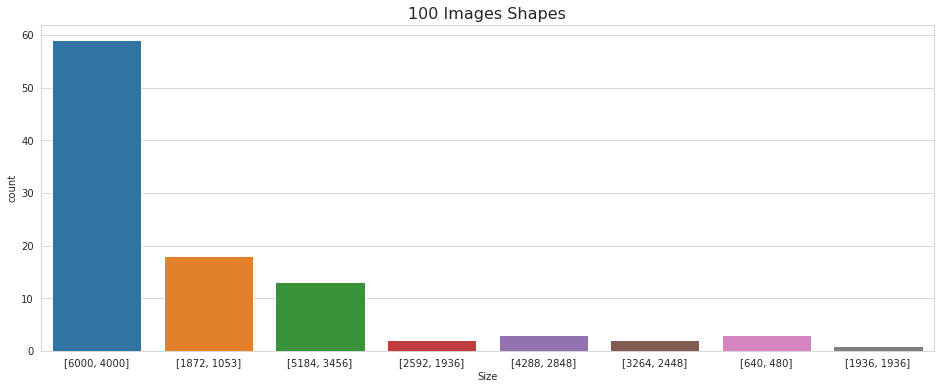

In [128]:
plt.figure(figsize = (16, 6))
sns.countplot(shapes_train['Size'])
plt.title('100 Images Shapes', fontsize=16)

Next we will view some of the benign and some of the malignant melanoma images from the dataset. 

In [129]:
def show_images(data, n = 5, rows=1, cols=5, title='Default'):
    plt.figure(figsize=(16,4))

    for k, path in enumerate(data['path_dicom'][:n]):
        image = pydicom.read_file(path)
        image = image.pixel_array
        
        # image = resize(image, (200, 200), anti_aliasing=True)

        plt.suptitle(title, fontsize = 16)
        plt.subplot(rows, cols, k+1)
        plt.imshow(image)
        plt.axis('off')

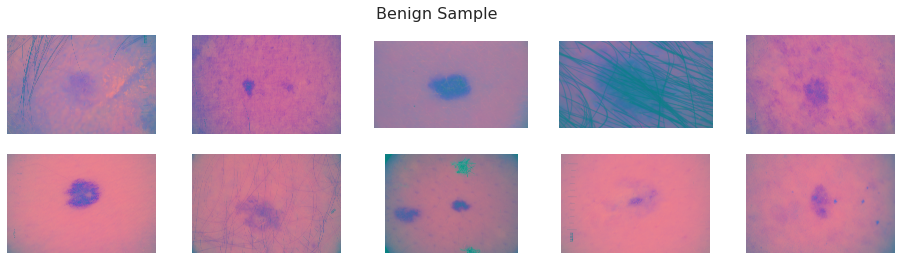

In [130]:
show_images(train_df[train_df['target'] == 0], n=10, rows=2, cols=5, title='Benign Sample')

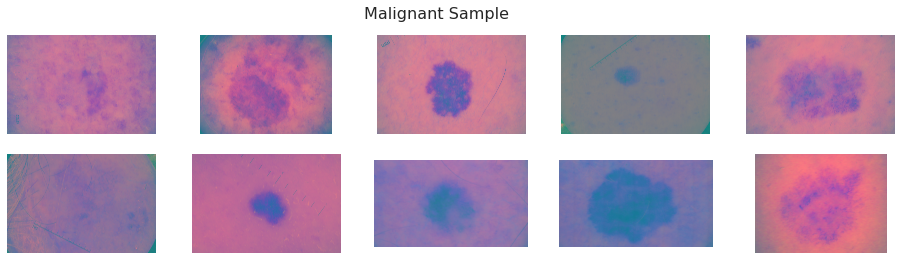

In [131]:
show_images(train_df[train_df['target'] == 1], n=10, rows=2, cols=5, title='Malignant Sample')

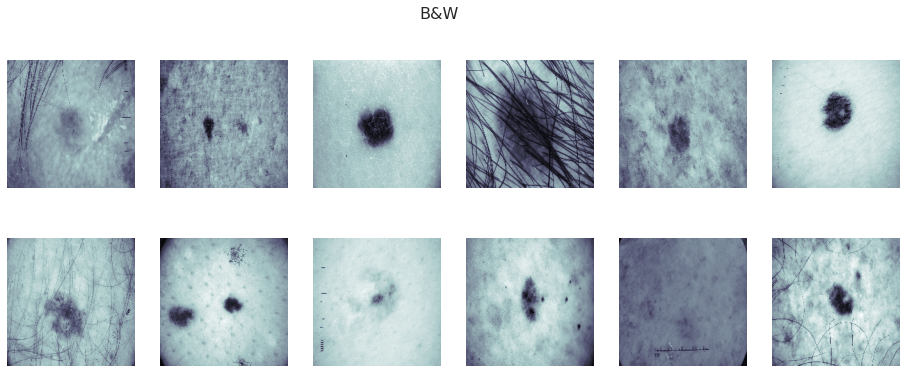

In [132]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("B&W", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

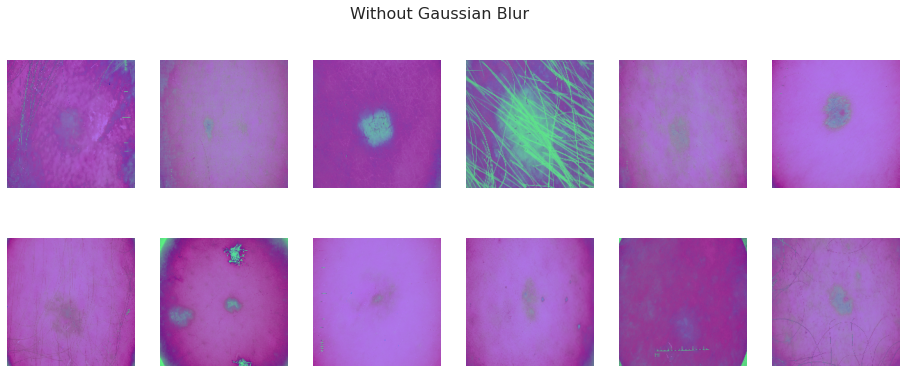

In [133]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Without Gaussian Blur", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    # Transform to B&W
    # The function converts an input image from one color space to another.
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

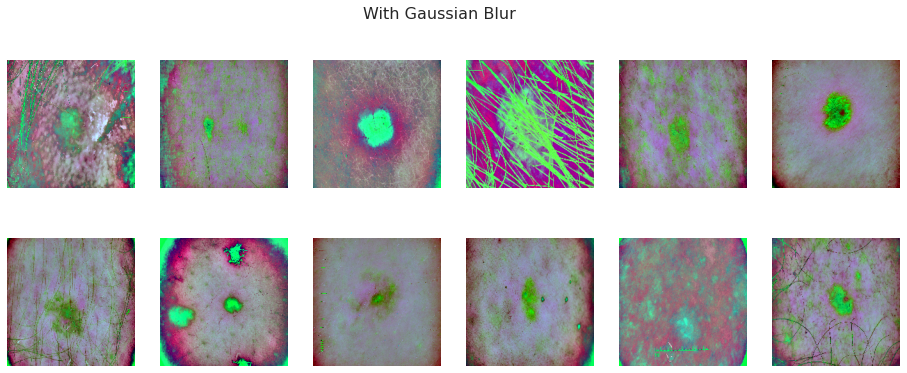

In [134]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("With Gaussian Blur", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image = cv2.resize(image, (200,200))
    image=cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0) ,256/10), -4, 128)
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

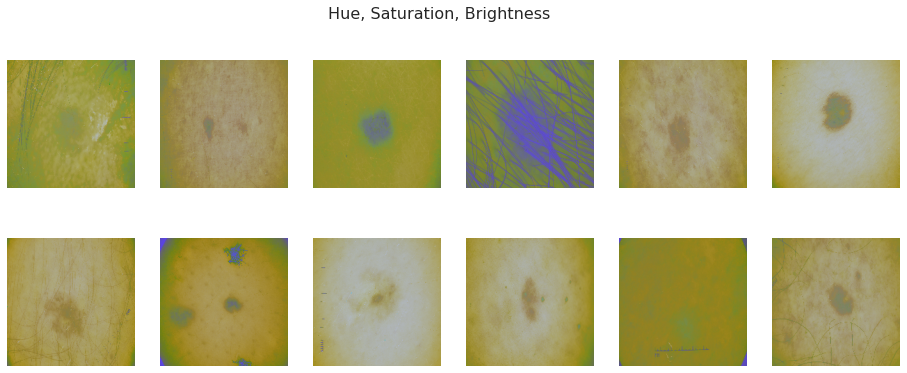

In [135]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("Hue, Saturation, Brightness", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

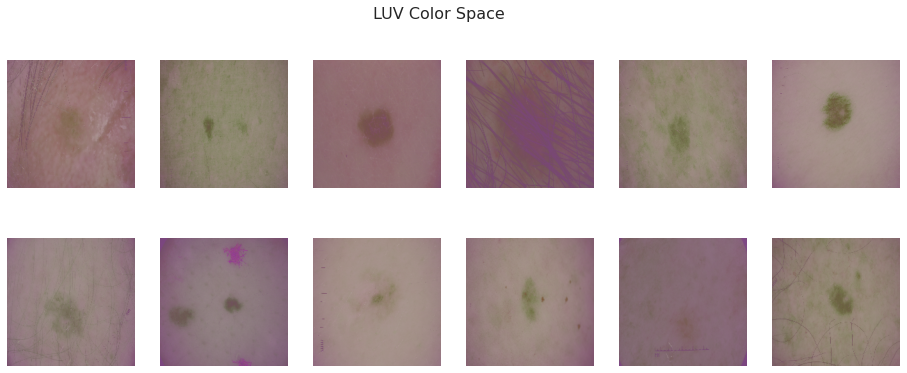

In [136]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16,6))
plt.suptitle("LUV Color Space", fontsize = 16)

for i in range(0, 2*6):
    data = pydicom.read_file(train_df['path_dicom'][i])
    image = data.pixel_array

    image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    image = cv2.resize(image, (200,200))
    
    x = i // 6
    y = i % 6
    axes[x, y].imshow(image, cmap=plt.cm.bone) 
    axes[x, y].axis('off')

In [137]:
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms 
import torch 
import torchvision

In [138]:
image_list = train_df.sample(12)['path_jpeg']
image_list = image_list.reset_index()['path_jpeg']

In [139]:
class DatasetExample(Dataset):
    def __init__(self, image_list, transforms=None):
        self.image_list = image_list
        self.transforms = transforms
    
    # To get item's length
    def __len__(self):
        return (len(self.image_list))
    
    # For indexing
    def __getitem__(self, i):
        # Read in image
        image = plt.imread(self.image_list[i])
        image = Image.fromarray(image).convert('RGB')        
        image = np.asarray(image).astype(np.uint8)
        if self.transforms is not None:
            image = self.transforms(image)
            
        return torch.tensor(image, dtype=torch.float)

In [140]:
def show_transform(image, title="Default"):
    plt.figure(figsize=(16,6))
    plt.suptitle(title, fontsize = 16)
    
    # Unnormalize
    image = image / 2 + 0.5  
    npimg = image.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


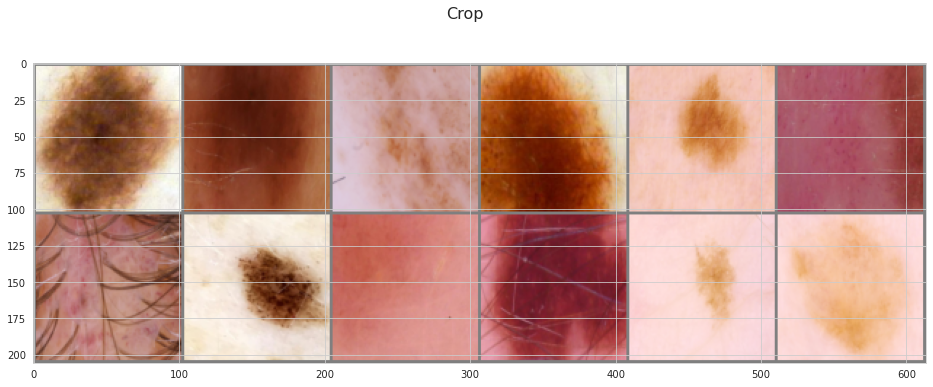

In [141]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.CenterCrop((100, 100)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Crop")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


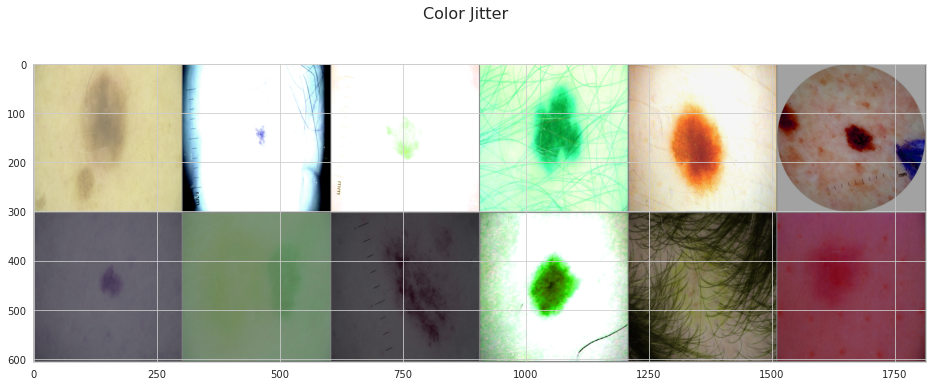

In [142]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Color Jitter")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


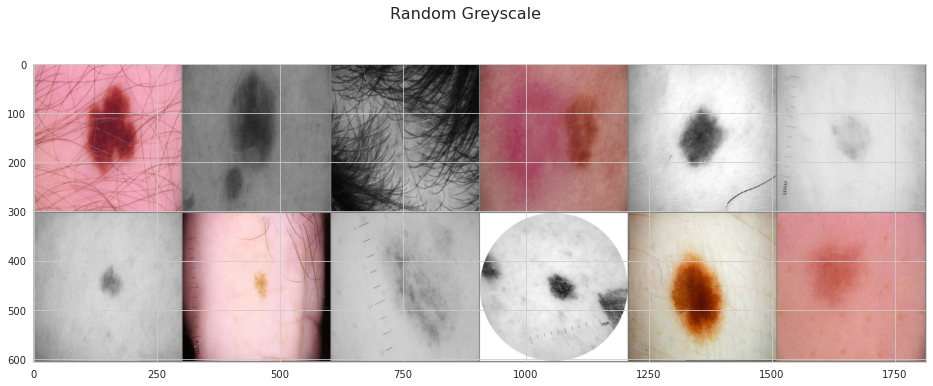

In [143]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.RandomGrayscale(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Random Greyscale")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


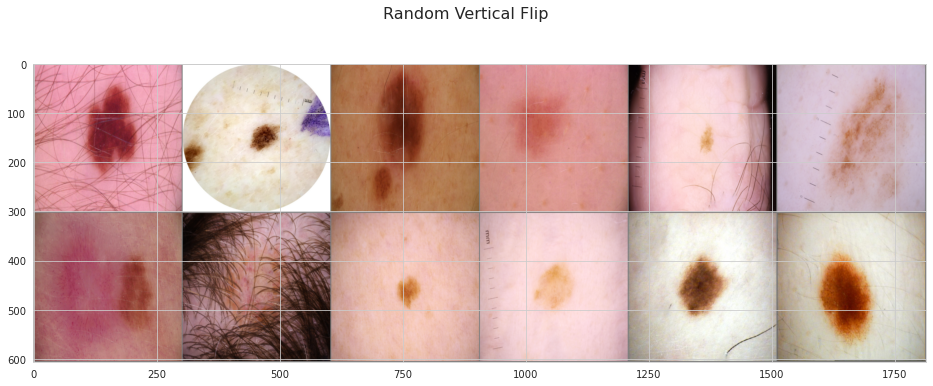

In [144]:
transform = transforms.Compose([
     transforms.ToPILImage(),
     transforms.Resize((300, 300)),
     transforms.RandomVerticalFlip(p=0.7),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

# Create the dataset
pytorch_dataset = DatasetExample(image_list=image_list, transforms=transform)
pytorch_dataloader = DataLoader(dataset=pytorch_dataset, batch_size=12, shuffle=True)

# Select the data
images = next(iter(pytorch_dataloader))
 
# show images
show_transform(torchvision.utils.make_grid(images, nrow=6), title="Random Vertical Flip")

In [145]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

In [166]:
import sklearn.preprocessing as preprocessing

In [177]:
output_size =1

In [167]:
label_encoder = LabelEncoder()

# --- Read in Test data (also cleaned, imputed, OHE) ---
test_df = pd.read_csv('test_clean.csv')

# Create path column to image folder for both Train and Test
path_train = '../input/melanoma-external-malignant-256/train/train/'
path_test = '../input/melanoma-external-malignant-256/test/test/'

train_df['path_jpg'] = path_train + train_df['image_name'] + '.jpg'
test_df['path_jpg'] = path_test + test_df['image_name'] + '.jpg'


# --- Last final thing: NORMALIZE! ---
train_df['age'] = train_df['age'].fillna(-1)

normalized_train = preprocessing.normalize(train_df[['sex', 'age', 'anatomy']])
normalized_test = preprocessing.normalize(test_df[['sex', 'age', 'anatomy']])

train_df['sex'] = normalized_train[:, 0]
train_df['age'] = normalized_train[:, 1]
train_df['anatomy'] = normalized_train[:, 2]

test_df['sex'] = normalized_test[:, 0]
test_df['age'] = normalized_test[:, 1]
test_df['anatomy'] = normalized_test[:, 2]


print('Len Train: {:,}'.format(len(train_df)), '\n' +
      'Len Test: {:,}'.format(len(test_df)))

Len Train: 33,126 
Len Test: 10,982


In [168]:
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['sex', 'age', 'anatomy']
no_columns = 3

In [172]:
class MelanomaDataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True, is_valid=False, is_test=False):
        self.dataframe, self.is_train, self.is_valid = dataframe, is_train, is_valid
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        
        # Data Augmentation (custom for each dataset type)
        if is_train or is_test:
            self.transform = Compose([RandomResizedCrop(height=224, width=224, scale=(0.4, 1.0)),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      HueSaturationValue(sat_shift_limit=[0.7, 1.3], 
                                                         hue_shift_limit=[-0.1, 0.1]),
                                      RandomBrightnessContrast(brightness_limit=[0.7, 1.3],
                                                               contrast_limit= [0.7, 1.3]),
                                      Normalize(),
                                      ToTensor()])
        else:
            self.transform = Compose([Normalize(),
                                      ToTensor()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        # Select path and read image
        image_path = self.dataframe['path_jpg'][index]
        image = cv2.imread(image_path)
        # For this image also import .csv information (sex, age, anatomy)
        csv_data = np.array(self.dataframe.iloc[index][['sex', 'age', 'anatomy']].values, 
                            dtype=np.float32)
        
        # Apply transforms
        image = self.transform(image=image)
        # Extract image from dictionary
        image = image['image']
        
        # If train/valid: image + class | If test: only image
        if self.is_train or self.is_valid:
            return (image, csv_data), self.dataframe['target'][index]
        else:
            return (image, csv_data)

In [179]:
import torch.nn as nn
from keras.applications.resnet50 import ResNet50

In [181]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = ResNet50(pretrained=True) # 1000 neurons out
        # (CSV data)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, csv_data, prints=False):
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints: print('CSV Data:', csv_data.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        # CLASSIF
        out = self.classification(image_csv_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [182]:
model_example = ResNet50Network(output_size=output_size, no_columns=no_columns)

ValueError: Unknown argument(s): {'pretrained': True}